# Title: Customising intertidal exposure calculations TODO: update <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule),
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)
* **Special requirements:** An _optional_ description of any special requirements, e.g. If running on the [NCI](https://nci.org.au/), ensure that `module load otps` is run prior to launching this notebook
* **Prerequisites:** An _optional_ list of any notebooks that should be run or content that should be understood prior to launching this notebook


## Background
### Intertidal Exposure



*Talk about applications and why it is useful to model exposure*

### Introduction to the Intertidal Exposure calculation method

DEA Intertidal Exposure models the percentage of time that any intertidal pixel of known elevation is exposed from tidal inundation. Exposure is calculated by comparing the pixel elevation back against a high temporal resolution model of tide heights for that location, based on an ensemble tidal modelling approach. Exposure percentage is calculated as the fraction of exposed observations relative to the total number of observations generated in the high temporal resolution tidal model for the 3-year product epoch.



| DEM | High temporal tide model |
|---|---|
| 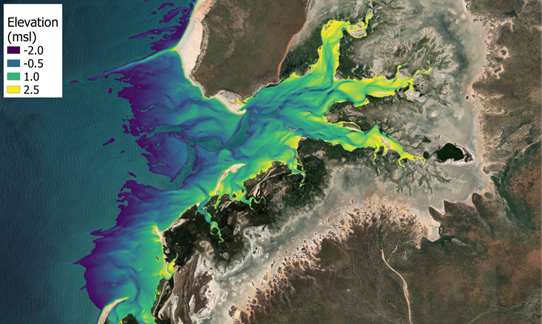 | 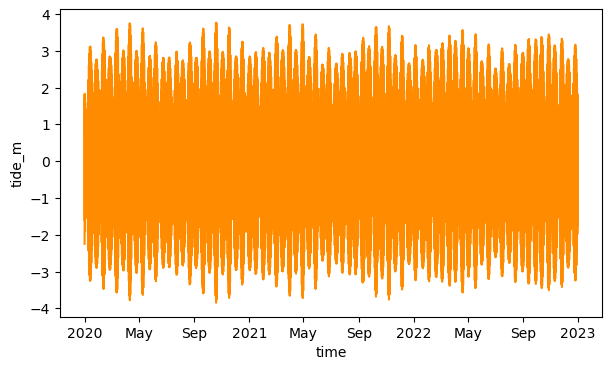 |

| Exposure Map | Percentile tide height distribution |
|---|---|
| 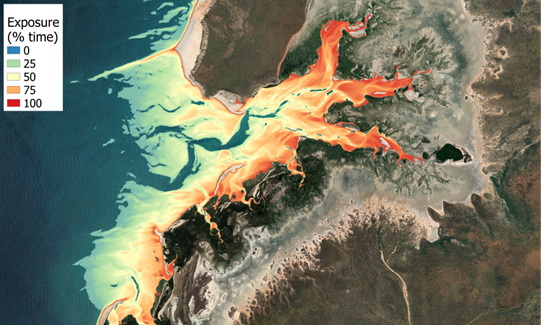 |  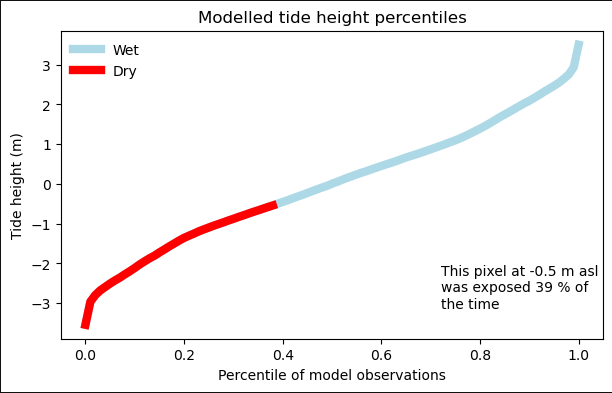 |
### Custom filtering of the Intertidal Exposure calculation

## Description

This notebook outlines the general methodology required to calculate intertidal exposure and demonstrates how tailored calculations can be used to investigate specific temporal or spatial influences on exposure times in intertidal ecosystems.

In this notebook, users will:
1. Use a conceptual model to understand how the intertidal exposure calculation is derived
2. Through the use of case studies in a given area of interest, calculate:

    - Full exposure characteristics
    - Temporally filtered exposure characteristics (e.g. wet-season exposure)
    - Spatially filtered exposure characteristics (e.g. high or low tide exposure times)
    - Spatiotemporal filtered exposure characteristics (e.g. wet-season high-tide exposure)

***

### Getting started

Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [ ]:
## Temporary cell - set the working directory to ensure links work properly.
%cd /home/jovyan/dea_intertidal/dea-intertidal

In [ ]:
## Temporary cell - Install additional packages directly from the requirements file
%pip install -r requirements.in --quiet

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from ipyleaflet import basemaps, basemap_to_tiles
import shapely

import datacube
import odc.geo.xr
# from odc.geo.geom import Geometry, BoundingBox
from datacube.utils.geometry import Geometry
from odc.algo import mask_cleanup
from odc.ui import select_on_a_map

from intertidal.utils import (
    round_date_strings,
    export_intertidal_rasters,
    intertidal_hillshade,
                            )
from intertidal.tide_modelling import pixel_tides_ensemble
from intertidal.elevation import load_data, load_topobathy, elevation
# from intertidal.extents import extents
from intertidal.exposure import exposure
# from intertidal.tidal_bias_offset import bias_offset, tidal_offset_tidelines 

from dea_tools.dask import create_local_dask_cluster

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [ ]:
dc = datacube.Datacube(app='Customising_Intertidal_Exposure')

### Analysis parameters

An *optional* section to inform the user of any parameters they'll need to configure to run the notebook:

* `param_name_1`: Simple description (e.g. `example_value`). Advice about appropriate values to choose for this parameter.
* `param_name_2`: Simple description (e.g. `example_value`). Advice about appropriate values to choose for this parameter.


In [ ]:
# Intertidal Elevation variables
start_date = "2019"  # Start date for analysis
end_date = "2021"  # End date for analysis
resolution = 300  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = True  # Filter to remove poorly georeferenced scenes?
tide_model = "ensemble"  # Tide model to use in analysis
tide_model_dir = "/gdata1/data/tide_models_clipped"

# Intertidal Exposure variables
modelled_freq = "3h"  # Frequency to run tidal model e.g '30min' or '1h'
# filters=[None] # Exposure filters.
# filters_combined = None ## Must be a list of tuples containing one temporal and spatial filter each

# Load coordinates for the analysis area of interest
# These coordinates are for an intertidal seagrass bed in the Port of Gladstone, QLD
study_area = 'Gladstone'
minx,miny = -23.85698, 151.31254
maxx, maxy = -23.87690, 151.33443
aoi_crs = 'EPSG:4326'

In [ ]:
# ?Geom

In [ ]:
# %store -r geom
# ?geom

In [ ]:
# # Load the data to calculate intertidal datasets

# %time

# # Generate the geometry for the area of interest
# # Geom = shapely.Polygon(((minx, miny),(minx,maxy),(maxx, maxy),(maxx,miny)))
# Geom = shapely.Polygon(((miny, maxx),(miny,minx),(maxy, minx),(maxy,maxx)))
# Geom = Geometry(Geom, crs=aoi_crs)

# # Connect to datacube
# # dc = datacube.Datacube(app="Intertidal_elevation")

In [ ]:
# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

satellite_ds = load_data(
    dc=dc,
    study_area=study_area,
    geom=Geom,
    time_range=(start_date, end_date),
    resolution=resolution,
    crs=crs,
    include_s2=True,
    include_ls=True,
    filter_gqa=filter_gqa,
    max_cloudcover=90,
    skip_broken_datasets=True,
)

print(satellite_ds)

# Load data
satellite_ds.load()

## Load Data
Plan: load data over Gladstone Harbour QLD. Use indexed elevation datasets with exposure codes and tide modelling.

## Calculate all epoch exposure
Plan: calculate exposure for all timesteps in the epoch. Briefly interpret results. Segue into case study examples.

## Case study 1 - temporal filtering of exposure
TODO - intertidal seagrass growing season example.

## Case study 2 - spatial filtering of exposure

Scenario: The 2024 QLD DES/DCCEEW Wetland Management Strategy identified goals and future directions for wetland management in Queensland.
These environments are critical to the success of shorebirds, including many migratory species and a wide range of seabirds.
The wetland management strategy identified two objectives relating to the mapping of shorebird habitat in Queensland:
1) Map and make available the location and shorebird use of high tide roost site information
2) Map and make available the location and shorebird use of shorebird feeding areas.

In this example, users will calculate intertidal exposure during average hightide periods to inform shorebird high tide roost site mapping.
Following this, the exercise will be repeated for average lowtide periods to inform calculations of foraging time and occupation space in low tide environments which are critical feeding environments for shore and sea birds.


## Case study 3 - spatiotemporal filtering of exposure

Building upon the seabird example from case study 2, in this example, also filter data for periods of migratory seabird presence in habitat areas of interest.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2021

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)